# グリッドサーチ

[INFO] Prophet予測プログラム (Curve Fitting版) を開始します
[INFO] データ数: 136件
[INFO] 学習期間: 2025-12-06 18:23:31 〜 2025-12-10 10:21:48
  [INFO] 学習データの形状から上限値(Cap)を推定中...
  [SUCCESS] カーブフィッティング成功 -> 推定Cap: 110.53 (現在値の 1.33倍)

[INFO] グリッドサーチを開始します...


15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:19 - cmdstanpy - INFO - Chain [1] done processing
15:36:22 - cmdstanpy - INFO - Chain [1] start processing
15:36:22 - cmdstanpy - INFO - Chain [1] done processing
15:36:25 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing
15:36:30 - cmdstanpy - INFO - Chain [1] start processing
15:36:31 - cmdstanpy - INFO - Chain [1] done processing
15:36:39 - cmdstanpy - INFO - Chain [1] start processing
15:36:40 - cmdstanpy - INFO - Chain [1] done processing
15:36:45 - cmdstanpy - INFO - Chain [1] start processing
15:36:46 - cmdstanpy - INFO - Chain [1] done processing
15:36:51 - cmdstanpy - INFO - Chain [1] start processing


  [RESULT] Best CV RMSE: 6.0044
  [RESULT] Best Params : {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}

[INFO] 最終モデルを構築中...


15:36:52 - cmdstanpy - INFO - Chain [1] done processing



[Final Test Results]
  RMSE : 1.36
  MAPE : 1.22%
[INFO] CSV保存完了: forecast_results_prophet_curvefit6-1.csv
[INFO] グラフを保存しました: forecast_plot_prophet_curvefit6-1.png

[INFO] 全工程完了


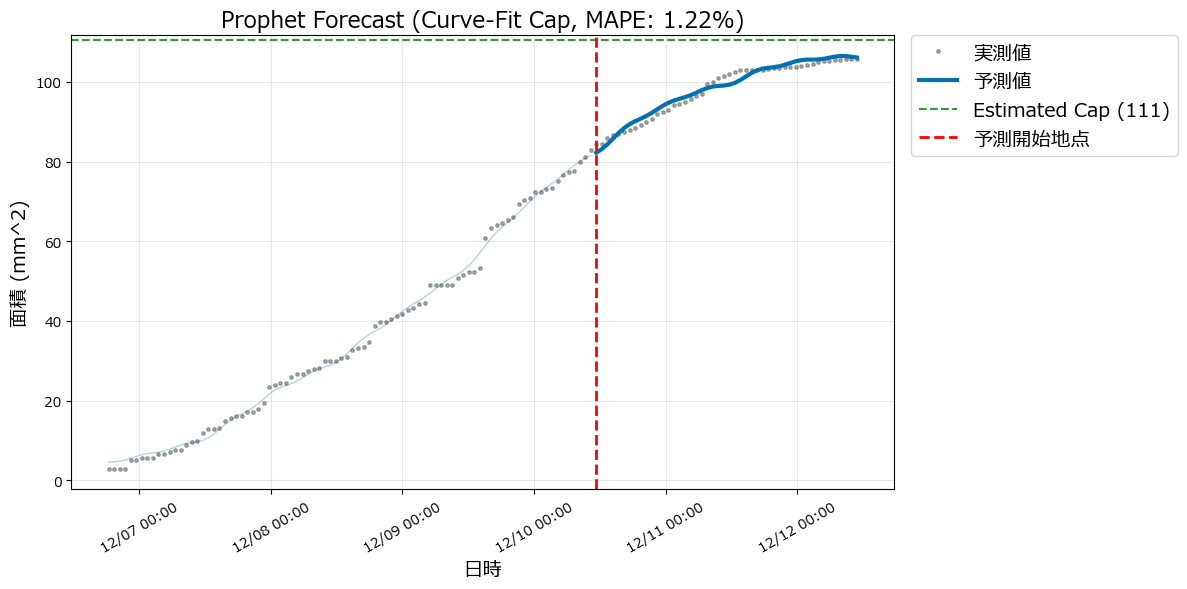

In [3]:
import os
import sys
import re
import itertools
from typing import Tuple, Optional, Dict, List, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error

# 日本語フォントの設定
try:
    import japanize_matplotlib
except ImportError:
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Meiryo', 'Yu Gothic', 'Hiragino Maru Gothic Pro']

# ==========================================
# 設定クラス
# ==========================================
class Config:
    """設定パラメータを管理するクラス"""
    INPUT_FILE = 'root_area_data_mm2_plant6-.xlsx'
    RESULT_CSV = 'forecast_results_prophet_curvefit6-1.csv'
    RESULT_IMG = 'forecast_plot_prophet_curvefit6-1.png'
    
    VALIDATION_DAYS = 2  # テスト期間（日）
    
    # グリッドサーチ探索範囲
    PARAM_GRID = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1],
        'seasonality_prior_scale': [1.0, 10.0],
    }
    
    # クロスバリデーション設定
    CV_PERIOD = "12 hours"
    CV_HORIZON = "24 hours"

# ==========================================
# 数理計算ヘルパー関数
# ==========================================
def extract_date(filename: str) -> Optional[pd.Timestamp]:
    """ファイル名から日時を抽出 (例: 20231010_120000)"""
    match = re.search(r'(\d{8})_(\d{6})', str(filename))
    if match:
        return pd.to_datetime(f"{match.group(1)} {match.group(2)}", format='%Y%m%d %H%M%S')
    return None

def logistic_func(t: np.ndarray, L: float, k: float, t0: float) -> np.ndarray:
    """
    ロジスティック関数
    L: キャリングキャパシティ（最大上限値）
    k: 成長率
    t0: 変曲点
    """
    return L / (1 + np.exp(-k * (t - t0)))

def estimate_carrying_capacity(df_train: pd.DataFrame) -> float:
    """
    学習データの形状からカーブフィッティングを用いてCap(上限値)を推定する
    """
    print("  [INFO] 学習データの形状から上限値(Cap)を推定中...")
    
    # 日付を経過日数(数値)に変換
    start_date = df_train['ds'].min()
    t_days = (df_train['ds'] - start_date).dt.total_seconds() / (24 * 3600)
    y_data = df_train['y'].values
    current_max = y_data.max()

    # 初期推定値 (L=1.5倍, k=1.0, t0=期間中央)
    p0 = [current_max * 1.5, 1.0, t_days.median()]

    # パラメータ制約 (Lは現在の最大値以上)
    bounds = ([current_max, 0, -np.inf], [np.inf, np.inf, np.inf])

    estimated_cap = current_max * 1.5  # デフォルト値（失敗時用）

    try:
        popt, _ = curve_fit(logistic_func, t_days, y_data, p0=p0, bounds=bounds, maxfev=10000)
        fit_cap = popt[0]
        
        # 異常値ガード: 推定値が現在の10倍を超える場合は過大とみなす
        if fit_cap > current_max * 10:
            print(f"  [WARN] 推定Cap({fit_cap:.2f})が過大です。安全策(2.0倍)を適用します。")
            estimated_cap = current_max * 2.0
        else:
            estimated_cap = fit_cap
            print(f"  [SUCCESS] カーブフィッティング成功 -> 推定Cap: {estimated_cap:.2f} (現在値の {estimated_cap/current_max:.2f}倍)")
            
    except Exception as e:
        print(f"  [WARN] フィッティング失敗 ({e})。安全策(1.5倍)を適用します。")
        estimated_cap = current_max * 1.5

    return estimated_cap

# ==========================================
# データ処理・学習関数
# ==========================================
def load_and_preprocess(filepath: str) -> Tuple[pd.DataFrame, str]:
    """データの読み込みと前処理"""
    if not os.path.exists(filepath):
        print(f"[ERROR] ファイル '{filepath}' が見つかりません。")
        sys.exit(1)
    
    try:
        df = pd.read_excel(filepath, engine='openpyxl')
    except Exception as e:
        print(f"[ERROR] 読み込み失敗: {e}")
        sys.exit(1)

    # カラム正規化
    if 'filename' not in df.columns:
        df.rename(columns={df.columns[0]: 'filename'}, inplace=True)
    df['ds'] = df['filename'].apply(extract_date)

    # ターゲット特定
    unit_label = "面積 (mm^2)"
    col_map = {
        'area_mm2': '面積 (mm^2)',
        'area_cm2': '面積 (cm^2)',
        'area_pixels': '面積 (pixels)'
    }
    
    target_col = None
    for col, label in col_map.items():
        if col in df.columns:
            target_col = col
            unit_label = label
            break
            
    if target_col is None:
        print("[ERROR] 面積データ列が見つかりません。")
        sys.exit(1)
        
    df['y'] = df[target_col]
    
    # クリーニング
    df_clean = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)
    return df_clean, unit_label

def split_data(df: pd.DataFrame, valid_days: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """学習用とテスト用に分割"""
    validation_len = valid_days * 24
    if len(df) <= validation_len:
        validation_len = int(len(df) * 0.2)
        
    train_size = len(df) - validation_len
    return df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

def optimize_prophet_params(df_train: pd.DataFrame, param_grid: Dict) -> Tuple[Dict, float]:
    """グリッドサーチによるパラメータ最適化"""
    print("\n[INFO] グリッドサーチを開始します...")
    
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    best_params = {}
    best_rmse = float('inf')
    
    # CV用期間設定
    data_duration = df_train['ds'].max() - df_train['ds'].min()
    initial_days = f"{int(data_duration.days * 0.5)} days"

    for i, params in enumerate(all_params):
        try:
            m = Prophet(growth='logistic', daily_seasonality=False, **params)
            m.add_seasonality(name='daily', period=1, fourier_order=3)
            m.fit(df_train)

            df_cv = cross_validation(m, initial=initial_days, 
                                   period=Config.CV_PERIOD, 
                                   horizon=Config.CV_HORIZON, 
                                   parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmse = df_p['rmse'].values[0]

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params
                
        except Exception:
            continue

    print(f"  [RESULT] Best CV RMSE: {best_rmse:.4f}")
    print(f"  [RESULT] Best Params : {best_params}")
    return best_params, best_rmse

def plot_results(df_clean, forecast, df_test, estimated_cap, unit_label, mape, output_path):
    """結果のプロット保存"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 実測値
    ax.plot(df_clean['ds'], df_clean['y'], 'k.', label='実測値', alpha=0.3, markersize=5)
    
    # 予測値（テスト期間）
    valid_start = df_test['ds'].min()
    forecast_valid = forecast[forecast['ds'] >= valid_start]
    ax.plot(forecast_valid['ds'], forecast_valid['yhat'], label='予測値', color='#0072B2', linewidth=3)
    
    # 予測値（学習期間・参考）
    forecast_train = forecast[forecast['ds'] < valid_start]
    ax.plot(forecast_train['ds'], forecast_train['yhat'], color='#0072B2', alpha=0.3, linewidth=1)
    
    # Capライン
    ax.axhline(y=estimated_cap, color='green', linestyle='--', 
               label=f'Estimated Cap ({estimated_cap:.0f})', alpha=0.8)
    
    # 境界線
    ax.axvline(x=valid_start, color='red', linestyle='--', label='予測開始地点', linewidth=2)
    
    ax.set_title(f'Prophet Forecast (Curve-Fit Cap, MAPE: {mape:.2%})', fontsize=16)
    ax.set_xlabel('日時', fontsize=14)
    ax.set_ylabel(unit_label, fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.xticks(rotation=30)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    print(f"[INFO] グラフを保存しました: {output_path}")

# ==========================================
# メイン処理
# ==========================================
def main():
    print("[INFO] Prophet予測プログラム (Curve Fitting版) を開始します")

    # 1. データ読み込み & 前処理
    df_clean, unit_label = load_and_preprocess(Config.INPUT_FILE)
    print(f"[INFO] データ数: {len(df_clean)}件")

    # 2. データ分割
    df_train, df_test = split_data(df_clean, Config.VALIDATION_DAYS)
    print(f"[INFO] 学習期間: {df_train['ds'].min()} 〜 {df_train['ds'].max()}")

    # 3. Cap（上限値）の自動推定
    # 学習データのトレンドのみを用いて数学的に推定する（リークなし）
    estimated_cap = estimate_carrying_capacity(df_train)
    df_train['cap'] = estimated_cap

    # 4. パラメータ最適化 (グリッドサーチ)
    best_params, _ = optimize_prophet_params(df_train, Config.PARAM_GRID)

    # 5. 最終モデル構築
    print("\n[INFO] 最終モデルを構築中...")
    m_final = Prophet(growth='logistic', daily_seasonality=False, **best_params)
    m_final.add_seasonality(name='daily', period=1, fourier_order=3)
    m_final.fit(df_train)

    # 6. 未来予測 (テストデータ区間含む)
    future = df_clean[['ds']].copy()
    future['cap'] = estimated_cap
    forecast = m_final.predict(future)

    # 7. 精度評価
    compare_df = pd.merge(df_test[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
    
    rmse, mape = 0.0, 0.0
    if not compare_df.empty:
        y_true = compare_df['y'].values
        y_pred = compare_df['yhat'].values
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        mask = y_true != 0
        if np.any(mask):
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))
            
        print(f"\n[Final Test Results]")
        print(f"  RMSE : {rmse:.2f}")
        print(f"  MAPE : {mape:.2%}")

    # 8. 保存
    cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']
    forecast[cols].to_csv(Config.RESULT_CSV, index=False, encoding='utf-8_sig')
    print(f"[INFO] CSV保存完了: {Config.RESULT_CSV}")

    # 9. 可視化
    plot_results(df_clean, forecast, df_test, estimated_cap, 
                 unit_label, mape, Config.RESULT_IMG)

    print("\n[INFO] 全工程完了")

if __name__ == "__main__":
    main()

#　LSTM

In [9]:
import os
import sys
import re
import random
from typing import Tuple, Optional, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 日本語フォントの設定
try:
    import japanize_matplotlib
except ImportError:
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Meiryo', 'Yu Gothic', 'Hiragino Maru Gothic Pro']

# ==========================================
# 設定クラス
# ==========================================
class Config:
    """設定パラメータ管理クラス"""
    INPUT_FILE = 'root_area_data_mm2_plant6-.xlsx'
    RESULT_CSV = 'lstm_prediction_result6-4.csv'
    RESULT_IMG = 'lstm_prediction_plot6-4.png'
    
    VALIDATION_DAYS = 2   # 検証期間 (日)
    LOOKBACK = 72         # 過去何時間分を見て予測するか
    EPOCHS = 100          # 学習エポック数
    BATCH_SIZE = 16       # バッチサイズ
    SEED = 42             # 乱数シード (再現性のため)

# ==========================================
# ヘルパー関数
# ==========================================
def set_seeds(seed: int = 42):
    """再現性のために乱数シードを固定する"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def extract_date(filename: str) -> Optional[pd.Timestamp]:
    """ファイル名から日時情報を抽出"""
    match = re.search(r'(\d{8})_(\d{6})', str(filename))
    if match:
        return pd.to_datetime(f"{match.group(1)} {match.group(2)}", format='%Y%m%d %H%M%S')
    return None

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """RMSEとMAPEを計算"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # ゼロ除算回避
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mape = np.nan_to_num(mape)
        
    return rmse, mape

# ==========================================
# データ処理関数
# ==========================================
def load_and_clean_data(filepath: str) -> Tuple[pd.DataFrame, str]:
    """データの読み込みとクリーニング"""
    if not os.path.exists(filepath):
        print(f"[ERROR] File not found: {filepath}")
        sys.exit(1)

    try:
        df = pd.read_excel(filepath, engine='openpyxl')
    except Exception as e:
        print(f"[ERROR] Load failed: {e}")
        sys.exit(1)
        
    # カラム名正規化
    if 'filename' not in df.columns:
        df.rename(columns={df.columns[0]: 'filename'}, inplace=True)
    df['ds'] = df['filename'].apply(extract_date)

    # ターゲット変数特定
    unit_label = "面積 (pixels)"
    target_col = None
    col_map = {
        'area_mm2': '面積 (mm^2)',
        'area_cm2': '面積 (cm^2)',
        'area_pixels': '面積 (pixels)'
    }
    
    for col, label in col_map.items():
        if col in df.columns:
            target_col = col
            unit_label = label
            break
            
    if target_col is None:
        # フォールバック: 2列目を使用
        if len(df.columns) >= 2:
            target_col = df.columns[1]
        else:
            print("[ERROR] No target column found.")
            sys.exit(1)
            
    df['y'] = df[target_col]
    df_clean = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)
    
    return df_clean, unit_label

def create_sequences(dataset: np.ndarray, lookback: int) -> Tuple[np.ndarray, np.ndarray]:
    """スライディングウィンドウ法でシーケンスデータを作成"""
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

def prepare_datasets(df: pd.DataFrame, config: Config) -> Tuple[Any, Any, Any, Any, Any, pd.Series]:
    """データの分割、スケーリング、シーケンス作成を一括で行う"""
    
    # 1. 学習/テスト分割位置の計算
    validation_len = config.VALIDATION_DAYS * 24
    train_size = len(df) - validation_len
    
    # 2. 配列化
    train_raw = df['y'].values[:train_size].reshape(-1, 1)
    test_raw = df['y'].values[train_size:].reshape(-1, 1)
    
    print(f"[INFO] Train size: {len(train_raw)}, Test size: {len(test_raw)}")

    # 3. スケーリング (学習データのみでfit)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_raw)
    
    # テストデータ準備: 直近LOOKBACK分を結合してtransform
    test_input_source = np.concatenate((train_raw[-config.LOOKBACK:], test_raw), axis=0)
    test_input_scaled = scaler.transform(test_input_source)

    # 4. シーケンス作成
    X_train, y_train = create_sequences(train_scaled, config.LOOKBACK)
    X_test, y_test = create_sequences(test_input_scaled, config.LOOKBACK)

    # LSTM入力形状へ変形 [samples, time_steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # テスト期間の日付（プロット用）
    test_dates = df['ds'].iloc[train_size:].reset_index(drop=True)

    return X_train, y_train, X_test, y_test, scaler, test_dates, train_size

# ==========================================
# モデル関連関数
# ==========================================
def build_lstm_model(input_shape: Tuple[int, int]) -> Sequential:
    """単方向LSTMモデルの構築"""
    model = Sequential([
        # 単方向LSTM (未来の情報を見ない)
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_results(df: pd.DataFrame, test_dates: pd.Series, 
                 y_pred: np.ndarray, train_size: int, 
                 unit_label: str, mape: float, output_path: str):
    """結果のグラフ描画と保存"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 全期間の実測値
    ax.plot(df['ds'], df['y'], 'k.', label='実測値', alpha=0.3, markersize=5)
    
    # 予測値
    ax.plot(test_dates, y_pred, label='予測値', color='#0072B2', linewidth=2)
    
    # 境界線
    boundary_date = df['ds'].iloc[train_size]
    ax.axvline(x=boundary_date, color='red', linestyle='--', label='予測開始地点', linewidth=2)
    
    ax.set_title(f'LSTM Forecast (Unidirectional, MAPE: {mape:.2f}%)', fontsize=16)
    ax.set_xlabel('日時', fontsize=14)
    ax.set_ylabel(unit_label, fontsize=14)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.xticks(rotation=30)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()
    print(f"[INFO] グラフを保存しました: {output_path}")

# ==========================================
# メイン処理
# ==========================================
def main():
    # 再現性の確保
    set_seeds(Config.SEED)
    print("[INFO] LSTM予測プログラム (Unidirectional) を開始します")

    # 1. データ読み込み
    df, unit_label = load_and_clean_data(Config.INPUT_FILE)
    
    if len(df) <= Config.LOOKBACK:
        print("[ERROR] データ数が不足しています。")
        return
        
    print(f"[INFO] Loaded: {Config.INPUT_FILE} ({len(df)} records)")

    # 2. データセット作成 (分割・スケーリング・シーケンス化)
    # ここでリーク防止の処理が含まれている
    X_train, y_train, X_test, y_test, scaler, test_dates, train_size = prepare_datasets(df, Config)
    
    print(f"[INFO] Training Samples: {X_train.shape[0]}")

    # 3. モデル構築 & 学習
    print("\n[INFO] モデル学習を開始します...")
    model = build_lstm_model((Config.LOOKBACK, 1))
    
    model.fit(
        X_train, y_train, 
        batch_size=Config.BATCH_SIZE, 
        epochs=Config.EPOCHS, 
        verbose=1
    )

    # 4. 予測実行
    print("\n[INFO] 予測を実行中...")
    predictions_scaled = model.predict(X_test, verbose=0)
    
    # 逆変換
    predictions_actual = scaler.inverse_transform(predictions_scaled)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 5. 評価
    rmse, mape = calculate_metrics(y_test_actual, predictions_actual)
    print(f"\n[Validation Results]")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  MAPE : {mape:.2f}%")

    # 6. CSV保存
    res_df = pd.DataFrame({
        'ds': test_dates.values,
        'y_actual': y_test_actual.flatten(),
        'y_pred': predictions_actual.flatten()
    })
    res_df.to_csv(Config.RESULT_CSV, index=False)
    print(f"[INFO] CSVを保存しました: {Config.RESULT_CSV}")

    # 7. グラフ保存
    plot_results(
        df=df,
        test_dates=test_dates,
        y_pred=predictions_actual,
        train_size=train_size,
        unit_label=unit_label,
        mape=mape,
        output_path=Config.RESULT_IMG
    )

    print("\n[INFO] 全ての処理が完了しました。")

if __name__ == "__main__":
    main()

[INFO] LSTM予測プログラム (Unidirectional) を開始します
[INFO] Loaded: root_area_data_mm2_plant6-.xlsx (136 records)
[INFO] Train size: 88, Test size: 48
[INFO] Training Samples: 16

[INFO] モデル学習を開始します...


C:\Users\admin\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7761
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.6267
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.5027
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.3993
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2906
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1892
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1014
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0334
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 9.0761e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0176
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0625
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0856
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0756
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0493
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0235
Epoc